#MLP from skratch using only Numpy applied to MNIST dataset

In order to better undertsand the maths behind Deep Learning algorithms we compute here a **MultiLayer Perceptron**, also called **fully connected neural network**, and its learning algorithm (**stochastic gradient descent**) with only math functions from Numpy and Python code. 

Our MLP will use a **cross-entropy loss function**. We will first implement it entirely from scratch, using only basic python primitives. Then, we will vectorize the forward and backward passes using NumPy.

1.   First, we implement a simple network following the characteristics of the image below, including the wieghts.
2. We then perform one forward pass
3. We update the loss 
4. And perform one backward pass

###The architecture
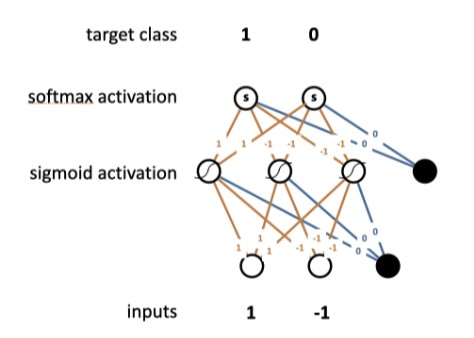


Imports

In [ ]:
from math import exp, log, sqrt

Implementation

In [ ]:
#First, we define the variable of our architecture
input_size=2
hidden_size=3
output_size=2

#Second, we define the parameters 

# Weights for 1st linear layer
w = [[1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]]
# Bias for 1st linear layer
b = [0.0, 0.0, 0.0]
# Weights for 2nd linear layer
v = [[1.0, 1.0], [-1.0, -1.0], [-1.0, -1.0]]
# Bias for 2nd linear layer
c = [0.0, 0.0]

#The target classes
target = [1.0,0.0]
#Input
x = [1.0, -1.0]


Forward pass

In [ ]:
#Then, we define the 
# Output from 1st linear layer
k = [sum(w[j][i] * x[j] for j in range(input_size)) + b[i] for i in range(hidden_size)]
# Output from sigmoid activation layer
h = [1 / (1 + exp(-k[i])) for i in range(hidden_size)]
# Output from 2nd linear layer
o = [sum(v[j][i] * h[j] for j in range(hidden_size)) + c[i] for i in range(output_size)]
# Output from softmax activation layer
denominator = sum(exp(o[i]) for i in range(output_size))
y = [exp(o[i]) / denominator for i in range(output_size)]
# Cross-entropy loss
loss = sum(-target[i] * log(y[i]) for i in range(output_size))

# Print loss
loss

0.6931471805599453

Backward propagation pass

In [ ]:
# Derivative of loss with respect to (wrt) the output from the softmax layer
d_y = [-target[i] * 1 / y[i] for i in range(output_size)]

# Derivative of loss wrt output from 2nd linear layer
d_o = [
    sum(
        d_y[i] * (y[i] * (1 - y[i]) if i == j else -y[i] * y[j])
        for i in range(output_size)
    )
    for j in range(output_size)
]
# Derivative of loss wrt weights of 2nd linear layer
d_v = [[d_o[j] * h[i] for j in range(output_size)] for i in range(hidden_size)]
# Derivative of loss wrt bias of 2nd linear layer
d_c = [d_o[i] for i in range(output_size)]
# Derivative of loss wrt output from sigmoid layer
d_h = [sum([d_o[j] * v[i][j] for j in range(output_size)]) for i in range(hidden_size)]
# Derivative of loss wrt output from 1st linear layer
d_k = [d_h[i] * h[i] * (1 - h[i]) for i in range(hidden_size)]
# Derivative of loss wrt weights of 1st linear layer
d_w = [[d_k[j] * x[i] for j in range(hidden_size)] for i in range(input_size)]
# Derivative of loss wrt bias of 1st linear layer
d_b = [d_k[i] for i in range(hidden_size)]

# Print derivatives
print(f"d_y: {d_y}")
print(f"d_o: {d_o}")
print(f"d_v: {d_v}")
print(f"d_c: {d_c}")
print(f"d_h: {d_h}")
print(f"d_k: {d_k}")
print(f"d_w: {d_w}")
print(f"d_b: {d_b}")

d_y: [-2.0, -0.0]
d_o: [-0.5, 0.5]
d_v: [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
d_c: [-0.5, 0.5]
d_h: [0.0, 0.0, 0.0]
d_k: [0.0, 0.0, 0.0]
d_w: [[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]]
d_b: [0.0, 0.0, 0.0]


###Training on dataset

We now want to see if our perceptron can train itself on a real dataset. First we charge a dataset. Then we develop a corresponding MLP with randomised weights and a training loop to see if the loss drops as training progresses.

In [ ]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [ ]:
(xtrain, ytrain), (xval, yval), num_cls = load_synth()
xtrain, ytrain, xval, yval, num_cls

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(array([[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788],
        ...,
        [-1.48486162,  0.46215981],
        [ 1.54902516,  2.53170549],
        [-0.03572203,  0.17320019]]),
 array([1, 1, 1, ..., 1, 1, 0]),
 array([[ 1.85658976, -1.5049403 ],
        [ 0.91501945, -1.24619226],
        [-0.65684037,  0.85767918],
        ...,
        [ 0.47922212, -1.29584025],
        [ 1.86307733,  0.27843612],
        [ 1.09374555, -0.2099617 ]]),
 array([1, 0, 0, ..., 0, 1, 1]),
 2)

###Implementing a training loop

We want to see if the loss drops as training progresses.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

Implementation

In [ ]:
# Learning rate
lr = 0.05
epochs = 1

# Define size of layers
input_size = xtrain.shape[1]
hidden_size = 3
output_size = num_cls

# normaly ditributed initialization of weights
w = [[np.random.normal(0,1,1)[0] for j in range(hidden_size)] for i in range(input_size)]
b = [0.0 for _ in range(hidden_size)]
v = [[np.random.normal(0,1,1)[0] for j in range(output_size)] for i in range(hidden_size)]
c = [0.0 for _ in range(output_size)]

Training loop

In [ ]:
losses = []
avg_losses = []

def MLP_learning(w, b, v, c, inputs, outputs, learning_rate, epochs):

    print(len(inputs))
    for l in range(epochs):
      for idx in range(len(inputs)):
        # let's map the x and the target
        x=inputs[idx]
        target = [1.0 if outputs[idx] == i else 0.0 for i in range(output_size)]

         # Forward pass
        k = [sum(w[j][i] * x[j] for j in range(input_size)) + b[i] for i in range(hidden_size)]
        h = [1 / (1 + exp(-k[i])) for i in range(hidden_size)]
        o = [sum(v[j][i] * h[j] for j in range(hidden_size)) + c[i] for i in range(output_size)]
        denominator = sum(exp(o[i]) for i in range(output_size))
        y = [exp(o[i]) / denominator for i in range(output_size)]
        loss = sum(-target[i] * log(y[i]) for i in range(output_size))
        losses.append(loss)

        # Backward pass
        d_y = [-target[i] * 1 / y[i] for i in range(output_size)]
        d_o = [
            sum(
                d_y[i] * (y[i] * (1 - y[i]) if i == j else -y[i] * y[j])
                for i in range(output_size)
            )
            for j in range(output_size)
        ]
        d_v = [[d_o[j] * h[i] for j in range(output_size)] for i in range(hidden_size)]
        d_c = [d_o[i] for i in range(output_size)]
        d_h = [sum([d_o[j] * v[i][j] for j in range(output_size)]) for i in range(hidden_size)]
        d_k = [d_h[i] * h[i] * (1 - h[i]) for i in range(hidden_size)]
        d_w = [[d_k[j] * x[i] for j in range(hidden_size)] for i in range(input_size)]
        d_b = [d_k[i] for i in range(hidden_size)]

        # Update weights & biases
        w = [[w[i][j] - lr * d_w[i][j] for j in range(hidden_size)] for i in range(input_size)]
        b = [b[i] - lr * d_b[i] for i in range(hidden_size)]
        v = [[v[i][j] - lr * d_v[i][j] for j in range(output_size)] for i in range(hidden_size)]
        c = [c[i] - lr * d_c[i] for i in range(output_size)]

      # avg_loss_prog.append(sum(loss_progression) / len(loss_progression))
      avg_losses.append(sum(losses)/len(losses))
    return losses

60000


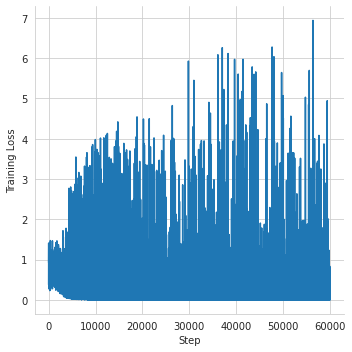

In [ ]:
MLP_learning(w, b, v, c, xtrain, ytrain, lr, epochs)

losses_df = pd.DataFrame(data={"Training Loss": losses, "Step": range(len(losses))})
sb.relplot(data=losses_df, y="Training Loss", x="Step", kind="line")

We can also do it with several epochs :

60000


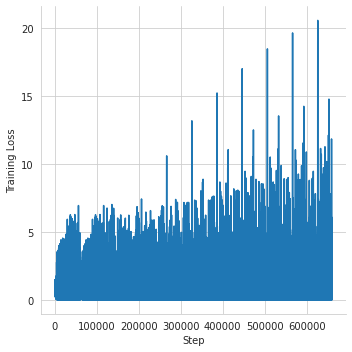

In [ ]:
MLP_learning(w, b, v, c, xtrain, ytrain, lr, 10)

losses_df = pd.DataFrame(data={"Training Loss": losses, "Step": range(len(losses))})
sb.relplot(data=losses_df, y="Training Loss", x="Step", kind="line")

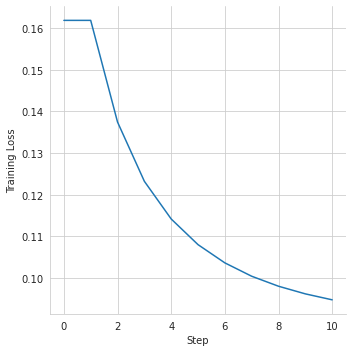

In [ ]:
avg_losses_df = pd.DataFrame(data={"Training Loss": avg_losses, "Step": range(len(avg_losses))})
sb.relplot(data=avg_losses_df, y="Training Loss", x="Step", kind="line")

##Vectorisation

Now, we want to vectorise the operations of our neural network. Vectorisation is very important because calculus using matrices are faster to write and faster to compute.

Because of the Vectorisation, we can represent our MLP with matrices and thus avoid a draw with hundreds of nodes and thousands of links.

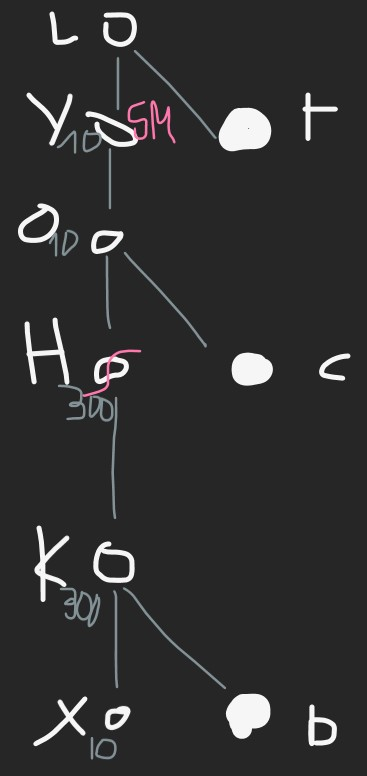

###Neural network for MNIST with vectorised operations

In [ ]:
def forward_pass(x, w, b, v, c, target):
    k = np.matmul(x, w.swapaxes(-1, -2)) + b
    h = 1.0 / (1.0 + np.exp(-k))
    o = np.matmul(h, v.swapaxes(-1, -2)) + c
    y = np.exp(o) / np.exp(o).sum(-1, keepdims=True)
    loss = (np.log(y) * -target).sum(axis=-1).mean()
    return k, h, o, y, loss


def backward_pass(x, y, target, h, v):
    d_y = -1.0 / y * target
    d_o = ((np.expand_dims(y, axis=-1) * np.eye(y.shape[-1])
     - np.matmul(np.expand_dims(y, axis=-1), np.expand_dims(y, axis=-2))
        )
        * np.expand_dims(d_y, axis=-1)
    ).sum(axis=1)
    d_v = np.matmul(np.expand_dims(d_o, axis=-1), np.expand_dims(h, axis=-2))
    d_c = 1.0 * d_o
    d_h = np.matmul(d_o, v)
    d_k = d_h * h * (1.0 - h)
    d_w = np.matmul(np.expand_dims(d_k, axis=-1), np.expand_dims(x, axis=-2))
    d_b = 1 * d_k
    return d_y, d_o, d_v, d_c, d_h, d_k, d_w, d_b


def training_loop(
    lr=0.1, hidden_size=300, batch_size=10, epochs=1, enable_logs=True, load_final=False, shuffle=True
):
    # Load data
    (xtrain, ytrain), (xval, yval), num_cls = load_mnist(final=load_final)
    # Normalize data
    xtrain = xtrain / 255.0
    xval = xval / 255.0

    # Define size of layers
    input_size = xtrain.shape[1]
    output_size = num_cls

    # Xavier initialization of weights
    w = np.random.uniform(
        -1 / sqrt(input_size), 1 / sqrt(input_size), size=(hidden_size, input_size)
    )
    b = np.zeros(shape=(hidden_size))
    v = np.random.uniform(
        -1 / sqrt(input_size), 1 / sqrt(input_size), size=(output_size, hidden_size)
    )
    c = np.zeros(shape=(output_size))
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    batch_loss = []

    for epoch in range(epochs):
        if shuffle:
            idxs = np.array(range(xtrain.shape[0]))
            np.random.shuffle(idxs)
            xtrain = xtrain[idxs]
            ytrain = ytrain[idxs]
        for idx in range(xtrain.shape[0] // batch_size):
            # Transform input and target values
            x = xtrain[idx * batch_size : idx * batch_size + batch_size]
            target = np.eye(output_size)[
                ytrain[idx * batch_size : idx * batch_size + batch_size]
            ]

            # Forward pass
            _, h, _, y, loss = forward_pass(x, w, b, v, c, target)
            batch_loss.append(loss)

            # Backward pass
            _, _, d_v, d_c, _, _, d_w, d_b = backward_pass(x, y, target, h, v)

            # Update weights & biases
            w = w - lr * d_w.mean(axis=0)
            b = b - lr * d_b.mean(axis=0)
            v = v - lr * d_v.mean(axis=0)
            c = c - lr * d_c.mean(axis=0)

        # Store loss & accuracy on training & validation set
        target = np.eye(output_size)[ytrain]
        _, _, _, y, tloss = forward_pass(xtrain, w, b, v, c, target)
        tacc = (y * target).sum(-1).mean()
        target = np.eye(output_size)[yval]
        _, _, _, y, vloss = forward_pass(xval, w, b, v, c, target)
        vacc = (y * target).sum(-1).mean()
        train_loss.append(tloss)
        val_loss.append(vloss)
        train_acc.append(tacc)
        val_acc.append(vacc)

        # Print average loss on validation set
        if enable_logs:
            print(f"epoch {epoch}: {vloss.mean()}")
    
    return train_loss, val_loss, batch_loss, train_acc, val_acc


In [ ]:
training_loop();

epoch 0: 0.2506069945804488


##Analysis
We now want to analyse our network results on MNIST and plot the learning curve (or loss curve).

epoch 0: 0.2145035462394235


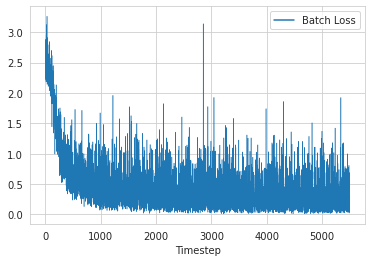

In [ ]:
_, _, batch_loss, _, _ = training_loop(lr=0.1, batch_size=10)

index = pd.Series(data=range(len(batch_loss)), name="Timestep")
batch_loss_df = pd.DataFrame(data=batch_loss, columns=["Batch Loss"], index=index)
sb.lineplot(data=batch_loss_df, linewidth=.5);

We compare the training loss per epoch to the validation loss per epoch.

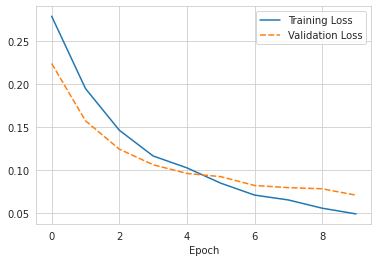

In [ ]:
train_loss, val_loss, _, _, _ = training_loop(enable_logs=False, epochs=10, lr=0.1, batch_size=10)

index = pd.Series(data=range(len(train_loss)), name="Epoch")
loss_df = pd.DataFrame(
    data={"Training Loss": train_loss, "Validation Loss": val_loss},
    index=index,
)
sb.lineplot(data=loss_df);

We can see that the validation loss is faster than the training loss but, at the end, the training loss is less than the validation one. 

We train the neural network from a random initialization multiple times (at least 3) and plot an average and a standard deviation of the objective value in each iteration. What does this tell you?

In [ ]:
total_train_loss = []
total_val_loss = []
total_train_acc = []
total_val_acc = []
epochs = []

for _ in range(10):
    train_loss, val_loss, _, train_acc, val_acc = training_loop(enable_logs=False, epochs=5, lr=0.1, batch_size=10)
    total_train_loss += train_loss
    total_val_loss += val_loss
    total_train_acc += train_acc
    total_val_acc += val_acc
    epochs += range(len(train_loss))

train_df = pd.DataFrame(data={"Loss": total_train_loss, "Accuracy": total_train_acc, "Epoch": epochs})
train_df["Type"] = "Training"
val_df = pd.DataFrame(data={"Loss": total_val_loss, "Accuracy": total_val_acc, "Epoch": epochs})
val_df["Type"] = "Validation"

total_loss_df = pd.concat([train_df, val_df])
sb.relplot(data=total_loss_df, x="Epoch", y="Loss", hue="Type", kind="line", errorbar="sd", linewidth=1.)
sb.relplot(data=total_loss_df, x="Epoch", y="Accuracy", hue="Type", kind="line", errorbar="sd", linewidth=1.);

Run the SGD with different learning rates. Analyze how the learning rate value influences the final performance.

In [ ]:
lr_configs = [0.01, 0.1, 1.0]
batch_configs = [1, 10, 100]

configs_df = None

for bc in batch_configs:
    for lc in lr_configs:
        _, val_loss, _, _, val_acc = training_loop(
            lr=lc, batch_size=bc, enable_logs=False, epochs=5
        )
        partial_df = train_df = pd.DataFrame(
            data={
                "Loss": val_loss,
                "Accuracy": val_acc,
                "Epoch": range(len(val_loss)),
            }
        )
        partial_df["Configuration"] = f"batch_{bc}__lr_{lc}"
        if configs_df is None:
            configs_df = partial_df
        else:
            configs_df = pd.concat([configs_df, partial_df])

configs_df = configs_df.reset_index()
sb.relplot(data=configs_df, x="Epoch", y="Loss", hue="Configuration", kind="line")
sb.relplot(data=configs_df, x="Epoch", y="Accuracy", hue="Configuration", kind="line")
configs_df[["Configuration", "Loss"]].groupby("Configuration").min()

Based on these experiments, choose a final set of hyperparameters. Then load the full training data with the canonical test set, train your model with the chosen hyperparameters and report the accuracy you get.

In [ ]:
train_loss, val_loss, _, train_acc, val_acc = training_loop(
    enable_logs=False, epochs=5, batch_size=1, lr=0.1, load_final=True
)

epochs = range(len(train_loss))
train_df = pd.DataFrame(data={"Loss": train_loss, "Accuracy": train_acc, "Epoch": epochs})
train_df["Type"] = "Training"
val_df = pd.DataFrame(data={"Loss": val_loss, "Accuracy": val_acc, "Epoch": epochs})
val_df["Type"] = "Test"

final_df = pd.concat([train_df, val_df])
print(f"Final accuracy: {val_acc[-1]}")
sb.relplot(data=final_df, x="Epoch", y="Loss", hue="Type", kind="line")
sb.relplot(data=final_df, x="Epoch", y="Accuracy", hue="Type", kind="line");